In [3]:
# Instrucciones de instalación:
!python -m pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

Looking in indexes: https://pypi.gurobi.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 19.5 MB/s eta 0:00:00


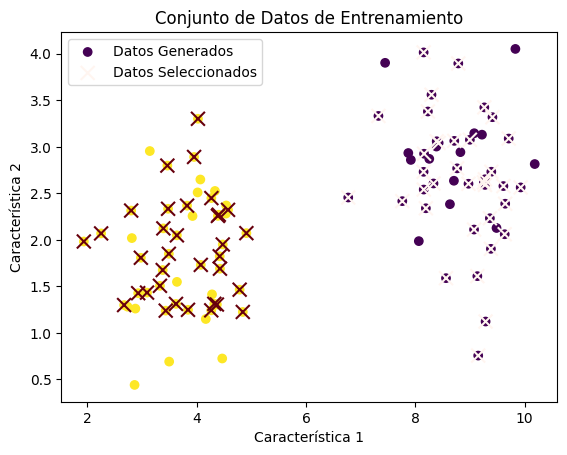

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import matplotlib

# generamos 100 muestras con dos características, asociadas a dos clases
X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=365, cluster_std=0.7)

# Seleccionar muestras específicas y transformarlas
indices_seleccionados = np.random.choice(len(X), size=70, replace=False)
X_entrenamiento = X[indices_seleccionados]
Y_entrenamiento = y[indices_seleccionados]
Y_entrenamiento[Y_entrenamiento == 0] = -1

#print("X_entrenamiento:\n", X_entrenamiento)
#print("Y_entrenamiento:\n", Y_entrenamiento)

# Visualizar los datos generados y seleccionados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Datos Generados')
plt.scatter(X_entrenamiento[:, 0], X_entrenamiento[:, 1], c=Y_entrenamiento, cmap='Reds', marker='x', s=100, label='Datos Seleccionados')
plt.title('Conjunto de Datos de Entrenamiento')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()

In [36]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Datos de entrenamiento
X = X_entrenamiento
y = Y_entrenamiento

# Crear el modelo
modelo = gp.Model("SVM_dual")

# Variables
m = len(X)
alfa = modelo.addMVar(m, lb=0.0, vtype=GRB.CONTINUOUS, name="alfa")

# Función objetivo
objetivo = 0.5 * gp.quicksum(alfa[i] * alfa[j] * y[i] * y[j] * np.dot(X[i], X[j]) for i in range(m) for j in range(m)) - gp.quicksum(alfa[i] for i in range(m))

# Restricciones
modelo.addConstr(gp.quicksum(alfa[i] * y[i] for i in range(m)) == 0, name="restriccion_lineal")


# Configurar el modelo para minimizar
modelo.setObjective(objetivo, GRB.MINIMIZE)

# Resolver el modelo
modelo.optimize()

# Obtener los resultados
alfa_optimo = np.array([alfa[i].x for i in range(m)])
#print("Multiplicadores de Lagrange óptimos:", alfa_optimo)

# Acceder al valor de las variables de decisión
valores_alfa = alfa.x
print("Valores de las variables de decisión:", valores_alfa)

# Encontrar índices de los vectores de soporte (los alfa que no son cero)
indices_soporte = np.where(alfa_optimo > 5e-1)[0]
#print(indices_soporte)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 70 columns and 70 nonzeros
Model fingerprint: 0x5d12bde8
Model has 2485 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [8e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 1 rows, 70 columns, 70 nonzeros
Presolved model has 2485 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.00000000e+04  0.00000000e+00  1.91

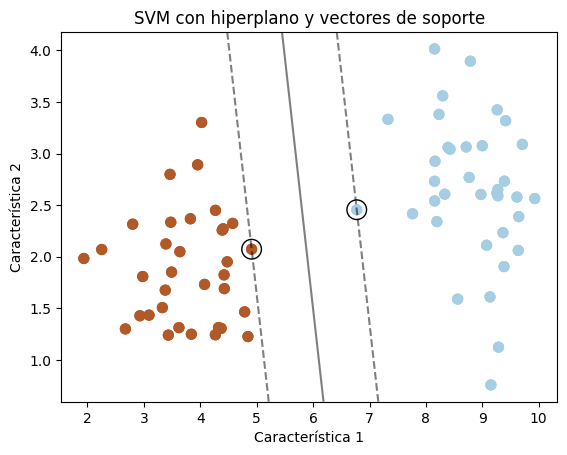

In [37]:
# Parámetros del hiperplano
w = np.sum((alfa_optimo[indices_soporte] * y[indices_soporte, np.newaxis]) * X[indices_soporte, :], axis=0)

# Término independiente
b = np.mean(y[indices_soporte] - np.dot(X[indices_soporte, :], w))

# Visualizar los datos y el hiperplano resultante
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', s=50)

# Graficar el hiperplano
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear la malla para graficar el hiperplano
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
xy = np.column_stack([xx.ravel(), yy.ravel()])

# Evaluar la función del hiperplano en la malla
Z = np.dot(xy, w) + b

# Graficar el hiperplano
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Resaltar los vectores de soporte
plt.scatter(X[indices_soporte, 0], X[indices_soporte, 1], s=200, facecolors='none', edgecolors='k')

# Agregar los puntos de entrenamiento al gráfico
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', s=50)

plt.title('SVM con hiperplano y vectores de soporte')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()